In [117]:
from PIL import Image
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from noise import pnoise2
import os
from glob import glob
from tqdm import tqdm

In [118]:
def show_image(image_name):    
    # AMAZON
    image_path = 'data/AMAZON/Training/image/' + image_name + '.tif'
    dataset = rasterio.open(image_path)
    # Note GetRasterBand() takes band no. starting from 1 not 0
    dataset_array = dataset.read()
    print(dataset_array.shape)
    print(dir(dataset))
    for band_idx in range(1, 5):
        band = dataset.read(band_idx)
        if band is None:
            print(f"No data for band: {band_idx}")
        else:
            imarray = band
            assert((imarray == dataset_array[band_idx - 1]).all())
            plt.figure()
            plt.imshow(imarray)
            print(f"Statistics for band {band_idx}:")
            print(f"Shape: {imarray.shape}")
            print(f"Min/Max: {np.min(imarray)}/{np.max(imarray)}")
            print(f"dtype: {imarray.dtype}")
            print(f"")

In [119]:
def show_label(image_name):
    # AMAZON Mask
    image_path = f'data/AMAZON/Training/label/{image_name}.tif'
    dataset = rasterio.open(image_path) 
    # Note GetRasterBand() takes band no. starting from 1 not 0
    mask_array = dataset.read(1)
    print(mask_array.shape)

    plt.figure()
    plt.imshow(mask_array)
    print(f"Shape: {mask_array.shape}")
    print(f"Min/Max: {np.min(mask_array)}/{np.max(mask_array)}")
    print(f"dtype: {mask_array.dtype}")

(4, 512, 512)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_size', 'block_window', 'block_windows', 'bounds', 'checksum', 'close', 'closed', 'colorinterp',

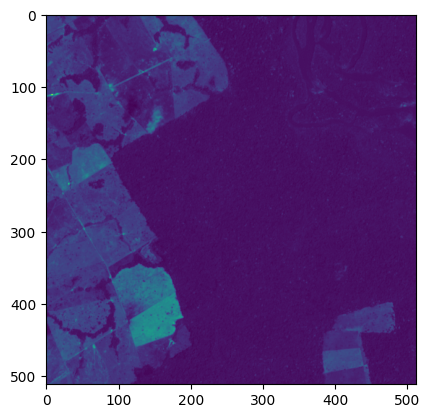

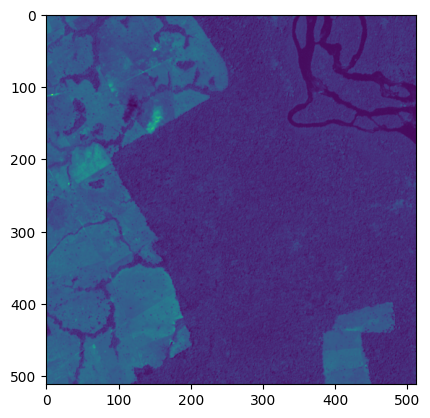

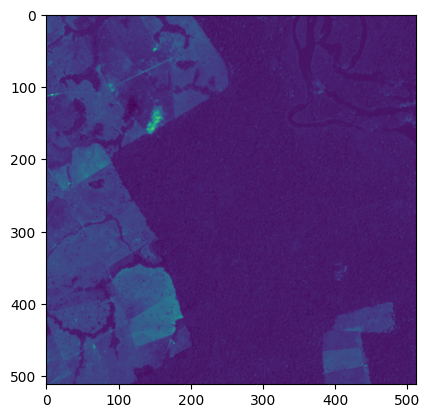

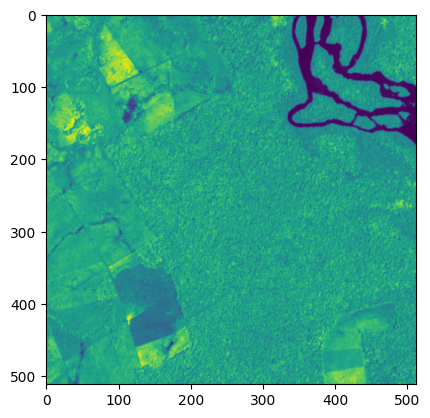

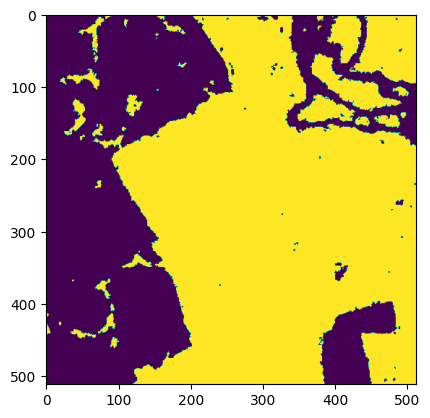

In [120]:
image_name = 'S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_13'
image_name = 'S2A_MSIL2A_20200115T140641_N0213_R110_T21LUH_20200115T163049_05_10'
show_image(image_name)
show_label(image_name)

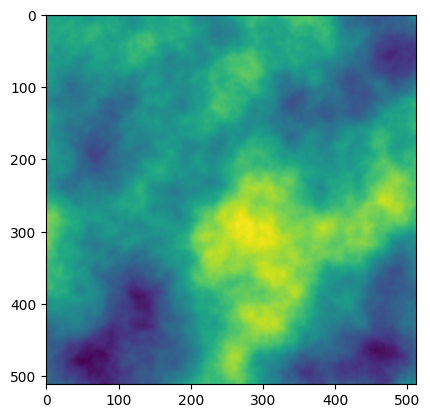

In [121]:
def generate_perlin_noise(width, height, scale=10, octaves=6, persistence=0.5, lacunarity=2.0):
    """Generate a 2D Perlin noise array."""
    noise_array = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise_value = pnoise2(i / scale, j / scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
            noise_array[i][j] = (noise_value + 1) / 2  # Normalize to 0-1
    noise_array = noise_array - noise_array.min()
    noise_array = noise_array / noise_array.max()
    return noise_array

plt.imshow(generate_perlin_noise(512, 512, scale=200, octaves=10))
plt.show()

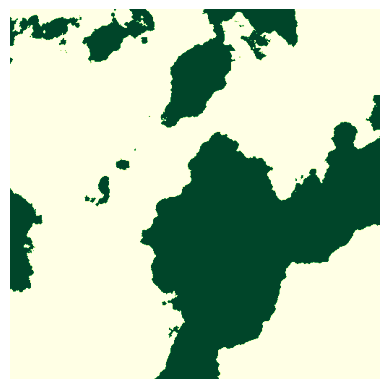

In [136]:
noise = generate_perlin_noise(512, 512, scale=200, octaves=10)

def imsave(image, name):
    plt.imshow(image, cmap='YlGn')
    plt.axis('off')
    # plt.show()
    plt.savefig(f"images/{name}.png", bbox_inches='tight')

imsave(noise, "noise")
imsave(noise>0.4, "noise1")
imsave(noise>0.6, "noise2")


In [122]:
def blend_images(image1, image2, mask, threshold):
    mask = mask < threshold
    # plt.imshow(mask)
    # plt.show()
    mask = np.expand_dims(mask, axis=0)
    mask = np.repeat(mask, image1.shape[0], axis=0)
    blended_image = image1 * (1 - mask) + image2 * mask
    return blended_image

In [123]:
image_name1 = 'S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_13'
image_name2 = 'S2A_MSIL2A_20200115T140641_N0213_R110_T21LUH_20200115T163049_05_10'

def merge_save_images(image_name1, image_name2, max_change=1.0):
    image_metadata = rasterio.open(f'data/AMAZON/Training/image/{image_name1}.tif').meta.copy()
    image1 = rasterio.open(f'data/AMAZON/Training/image/{image_name1}.tif').read()
    image2 = rasterio.open(f'data/AMAZON/Training/image/{image_name2}.tif').read()
    image1_label = rasterio.open(f'data/AMAZON/Training/label/{image_name1}.tif').read()
    image2_label = rasterio.open(f'data/AMAZON/Training/label/{image_name2}.tif').read()
    label_metadata = rasterio.open(f'data/AMAZON/Training/label/{image_name1}.tif').meta.copy()


    # plt.imshow(image1[0])
    # plt.show()
    # plt.imshow(image2[0])
    # plt.show()
    # mask = np.random.random(size=image1.shape[1:])
    mask = generate_perlin_noise(image1.shape[2], image1.shape[1], scale=200)
    mask[image1_label[0] < 0.5] = 1.1
    mask[image2_label[0] > 0.5] = 1.1
    
    # print(blend_images(image1, image2, mask, 0))
    print(np.mean(blend_images(image1, image2, mask, 0) == image2))

    date_range = np.arange(np.datetime64('2018-01-12'), np.datetime64('2024-04-28'), np.timedelta64(4, 'W'))
    for date, threshold in zip(date_range, np.linspace(0, max_change, len(date_range))):
        image_blended = blend_images(image1, image2, mask, threshold)
        # set all values where image1_label > 0.5 to image1
        # image_blended = np.where(image1_label > 0.5, image1, image_blended)
        date_dir = f'data/app/{image_name1}/{date}'
        if not os.path.exists(date_dir):
            os.makedirs(date_dir)
        # print(image_blended.shape)
        # print(image_metadata)
        with rasterio.open(f'{date_dir}/image.tif', 'w', **image_metadata) as dst:
            dst.write(image_blended)
        label_blended = blend_images(image1_label, image2_label, mask, threshold)
        # print(label_blended.shape)
        with rasterio.open(f'{date_dir}/label.tif', 'w', **label_metadata) as dst:
            dst.write(label_blended)
        # with rasterio.open(f'{date_dir}/mask.tif', 'w', **label_metadata) as dst:
        #     # transform 0-1 to 0-255
        #     dst.write((mask<threshold)*255, 1)
        # plt.pause(0.01)

np.random.seed(0)
image_name1 = 'S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_13'
image_name2 = 'S2A_MSIL2A_20200115T140641_N0213_R110_T21LUH_20200115T163049_05_10'
merge_save_images(image_name1, image_name2)

0.0017652511596679688


In [126]:
input_images = glob('data/AMAZON/Training/image/*.tif')
np.random.seed(42)
pairs = list(zip(np.random.choice(input_images, len(input_images)), np.random.choice(input_images, len(input_images))))[:10]
for image_name1, image_name2 in tqdm(pairs):
    image_name1 = image_name1.split('/')[-1].split('.')[0]
    image_name2 = image_name2.split('/')[-1].split('.')[0]
    print(image_name1, image_name2)
    max_change = np.random.rand() * (np.random.rand() > 0.2)
    merge_save_images(image_name1, image_name2, max_change=max_change)

  0%|          | 0/10 [00:00<?, ?it/s]

S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_10_11 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_08_08
0.0005407333374023438


 10%|█         | 1/10 [00:03<00:32,  3.58s/it]

S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_21_01 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_18_06
0.001537322998046875


 20%|██        | 2/10 [00:06<00:25,  3.15s/it]

S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_02_21 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_17_19
0.0007419586181640625


 30%|███       | 3/10 [00:09<00:21,  3.09s/it]

S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_10_19 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_01_12
0.0008459091186523438


 40%|████      | 4/10 [00:12<00:18,  3.09s/it]

S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_16_16 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_11_13
0.0013246536254882812


 50%|█████     | 5/10 [00:15<00:15,  3.14s/it]

S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_09_09 S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_09_17
0.0017910003662109375


 60%|██████    | 6/10 [00:21<00:16,  4.10s/it]

S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_06_01 S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_17_06
0.0013647079467773438


 70%|███████   | 7/10 [00:23<00:09,  3.30s/it]

S2B_MSIL2A_20200202T141649_N0213_R010_T20LQN_20200202T164215_18_10 S2A_MSIL2A_20200115T140641_N0213_R110_T21LUH_20200115T163049_05_03
0.0015621185302734375


 80%|████████  | 8/10 [00:25<00:05,  2.83s/it]

S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_10_11 S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_15_13
0.004055023193359375


 90%|█████████ | 9/10 [00:27<00:02,  2.72s/it]

S2A_MSIL2A_20200818T142741_N0214_R053_T20LMP_20200818T165705_08_03 S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_07_04
0.0007104873657226562


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]
